# Model Evaluations

> This module contains some functions to evaluate your model in-depth

- skip_showdoc: true
- skip_exec: true

In [ ]:
#| default_exp evaluations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from that_nlp_library.text_transformation import *
from that_nlp_library.text_augmentation import *
from that_nlp_library.text_main import *

In [ ]:
from underthesea import text_normalize
from functools import partial
from pathlib import Path
from importlib.machinery import SourceFileLoader
from transformers import DataCollatorWithPadding


## Single-head/Multi-head Classification

First, we will fully train and evaluate our model on a train/validation set

## Load data

In [ ]:
txt_tfms=[text_normalize]

over_nonown_tfm = partial(sampling_with_condition,query='Source=="non owned"',frac=0.5,seed=42,apply_to_all=False)
over_nonown_tfm.__name__ = 'Oversampling Non Owned'
over_own_tfm = partial(sampling_with_condition,query='Source=="owned"',frac=2,seed=42,apply_to_all=False)
over_own_tfm.__name__ = 'Oversampling Owned'
over_hc_tfm = partial(sampling_with_condition,query='Source=="hc search"',frac=2.5,seed=42,apply_to_all=False)
over_hc_tfm.__name__ = 'Oversampling HC search'
remove_accent_tfm = partial(remove_vnmese_accent,frac=1,seed=42,apply_to_all=True)
remove_accent_tfm.__name__ = 'Add No-Accent Text'
aug_tfms = [over_nonown_tfm,over_own_tfm,over_hc_tfm,remove_accent_tfm]

In [ ]:
DATA_PATH = Path('sample_data')

tdm = TextDataMain.from_csv(DATA_PATH/'sample_large.csv',
                            return_df=False,
                            main_content='Content',
                            metadatas='Source',
                            label_names='L1',
                            val_ratio=0.2,
                            split_cols='L1',
                            content_tfms = txt_tfms,
                            aug_tfms = aug_tfms,
                            process_metadatas=True,
                            seed=42,
                            shuffle_trn=True)

cache_dir=Path('./envibert_tokenizer')
tokenizer = SourceFileLoader("envibert.tokenizer", 
                             str(cache_dir/'envibert_tokenizer.py')).load_module().RobertaTokenizer(cache_dir)


----- Input Validation Precheck -----
DataFrame contains duplicated values!
-----> Number of duplications: 16 rows


In [ ]:
main_ddict= tdm.to_datasetdict(tokenizer,
                                max_length=512,
                              )

-------------------- Start Main Text Processing --------------------
----- Metadata Simple Processing & Concatenating to Main Content -----
----- Label Encoding -----
-------------------- Text Transformation --------------------
----- text_normalize -----


100%|█████████████████████████████████████| 2269/2269 [00:00<00:00, 3931.61it/s]


-------------------- Train Test Split --------------------
Previous Validation Percentage: 20.009%
- Before leak check
Size: 454
- After leak check
Size: 447
- Number of rows leaked: 7, or 1.54% of the original validation (or test) data
Current Validation Percentage: 19.7%
-------------------- Text Augmentation --------------------
Train data size before augmentation: 1822
----- Oversampling Non Owned -----
Train data size after THIS augmentation: 2020
----- Oversampling Owned -----
Train data size after THIS augmentation: 2248
----- Oversampling HC search -----
Train data size after THIS augmentation: 2390
----- Add No-Accent Text -----


100%|████████████████████████████████████| 2390/2390 [00:00<00:00, 19307.67it/s]


Train data size after THIS augmentation: 4780
Train data size after ALL augmentation: 4780
-------------------- Map Tokenize Function --------------------


Map:   0%|          | 0/4780 [00:00<?, ? examples/s]

Map:   0%|          | 0/447 [00:00<?, ? examples/s]

## Define and train model

In [ ]:
from that_nlp_library.models.roberta.classifiers import *
from that_nlp_library.model_main import *
from sklearn.metrics import f1_score, accuracy_score
import os

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
from transformers.models.roberta.modeling_roberta import RobertaModel

In [ ]:
model_name='nguyenvulebinh/envibert'

envibert_body = RobertaModel.from_pretrained(model_name)

Some weights of the model checkpoint at nguyenvulebinh/envibert were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
num_classes = len(tdm.label_lists[0])

In [ ]:
_model_kwargs={
    # overall model hyperparams
    'layer2concat':4,
    'is_multilabel':tdm.is_multilabel, # False
    'is_multihead':tdm.is_multihead, # False
    'head_class_sizes':num_classes,
    'head_class': ConcatHeadSimple,
    # classfication head hyperparams
    'classifier_dropout':0.1 
}

model = model_init_classification(model_class = RobertaHiddenStateConcatForSequenceClassification,
                                  cpoint_path = model_name, 
                                  output_hidden_states=True, # since we are not using 'hidden layer contatenation' technique
                                  seed=42,
                                  body_model=envibert_body,
                                  model_kwargs = _model_kwargs)

metric_funcs = [partial(f1_score,average='macro'),accuracy_score] # we will use both f1_macro and accuracy score as metrics
controller = ModelController(model,tdm,metric_funcs)

Loading body weights. This assumes the body is the very first first-layer block of your custom architecture


In [ ]:
lr = 8e-5
bs=4
wd=0.01
epochs= 2

controller.fit(epochs,lr,
               batch_size=bs,
               weight_decay=wd,
               save_checkpoint=False,
               compute_metrics=compute_metrics_classification,
              )

Epoch,Training Loss,Validation Loss,F1 Score L1,Accuracy Score L1
0,No log,0.933689,0.395291,0.695749
1,No log,0.942117,0.488467,0.706935


## Generate predictions

We will do model evaluation on the validation set. You can also perform model evalution on the training set using similar approach

In [ ]:
df_val = controller.predict_ddict(ds_type='validation')

-------------------- Start making predictions --------------------


Map:   0%|          | 0/447 [00:00<?, ? examples/s]

In [ ]:
df_val['label']= df_val['label'].apply(lambda x: tdm.label_lists[0][x]).values

In [ ]:
df_val.head()

,text,label,Source,pred_L1,pred_prob_L1
0,google play - Chơi gam rất là lác,Feature,google play,Commercial,0.751953
1,google play - Zq,Others,google play,Others,0.980518
2,non owned - Làn sóng kỹ thuật số và sự lựa chọ...,Others,non owned,Others,0.965513
3,google play - Hàng quốc tế không còn ship COD ...,Payment,google play,Delivery,0.923603
4,google play - Quá tệ . Giao hàng chậm như rùa ...,Delivery,google play,Delivery,0.919842


In [ ]:
df_val.Source.value_counts()

Source
google play    280
non owned      102
owned           25
ios             24
hc search       16
Name: count, dtype: int64

## Start the model evaluation

In [ ]:
#| export
from __future__ import annotations
from that_nlp_library.utils import *
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#| hide
#| export
def _show_metrics(label,pred,metric_funcs):
    results=''
    for m_func in metric_funcs:
        m_name=callable_name(m_func)
        results+=f'{m_name}: {m_func(label,pred):.4f} . '
    return results

In [ ]:
#| export
def evaluate_classification_model_metadata(df:pd.DataFrame, # The main dataframe containing the predictions
                                           metadatas:str|list, # Metadata(s) to perform analysis
                                           label_name:str, # Label's column name
                                           pred_name:str, # Prediction's column name
                                           metric_funcs:list, # Metric(s) to calculate
                                          ):
    metadatas = val2iterable(metadatas)
    metric_funcs = val2iterable(metric_funcs)
    
    for metadata in metadatas:
        print_msg(f'{label_name} Analysis on metadata: {metadata}',20)
        print_msg('Distribution',10)
        print(pd.concat((df[metadata].value_counts(),df[metadata].value_counts(normalize=True)),axis=1))
        print()
        print_msg(f'Metrics for each value in {metadata}',10)
        print(f'- For all data:\n{_show_metrics(df[label_name].values,df[pred_name].values,metric_funcs)}')
        for val in np.sort(df[metadata].unique()):
            y_true=df.loc[df[metadata]==val,label_name].values
            y_pred=df.loc[df[metadata]==val,pred_name].values
            print(f'- For {val}:\n{_show_metrics(y_true,y_pred,metric_funcs)}')

In [ ]:
show_doc(evaluate_classification_model_metadata)

---

[source](https://github.com/anhquan0412/that-nlp-library/blob/main/that_nlp_library/evaluations.py#L24){target="_blank" style="float:right; font-size:smaller"}

### evaluate_classification_model_metadata

>      evaluate_classification_model_metadata (df:pandas.core.frame.DataFrame,
>                                              metadatas:str|list,
>                                              label_name:str, pred_name:str,
>                                              metric_funcs:list)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| df | pd.DataFrame | The main dataframe containing the predictions |
| metadatas | str \| list | Metadata(s) to perform analysis |
| label_name | str | Label's column name |
| pred_name | str | Prediction's column name |
| metric_funcs | list | Metric(s) to calculate |

In [ ]:
metric_funcs = [partial(f1_score,average='macro'),accuracy_score]

In [ ]:
evaluate_classification_model_metadata(df_val,metadatas='Source',
                                       label_name='label',
                                       pred_name='pred_L1',
                                       metric_funcs=metric_funcs
                                      )

-------------------- label Analysis on metadata: Source --------------------
---------- Distribution ----------
             count  proportion
Source                        
google play    280    0.626398
non owned      102    0.228188
owned           25    0.055928
ios             24    0.053691
hc search       16    0.035794

---------- Metrics for each value in Source ----------
- For all data:
f1_score: 0.4952 . accuracy_score: 0.7092 . 
- For google play:
f1_score: 0.4857 . accuracy_score: 0.6929 . 
- For hc search:
f1_score: 0.4315 . accuracy_score: 0.6250 . 
- For ios:
f1_score: 0.6736 . accuracy_score: 0.7083 . 
- For non owned:
f1_score: 0.3407 . accuracy_score: 0.7647 . 
- For owned:
f1_score: 0.4146 . accuracy_score: 0.7200 . 


In [ ]:
#| export
def show_top_n_predictions(df:pd.DataFrame, # The main dataframe containing the predictions
                          text_name:str, # Text's column name
                          label_name:str, # Label's column name
                          pred_name:str, # Prediction's column name
                          prob_name:str, # Prediction probability's column name
                          is_incorrect=True, # To show top correct or incorrect sentences
                          ascending=False, # To sort by prob_name ascendingly or descendingly
                          n_show=10, # Number of sentences to show
                         ):
    if is_incorrect:
        df = df[df[pred_name]!=df[label_name]]
    else:
        df = df[df[pred_name]==df[label_name]]
    df = df.sort_values(prob_name,ascending=ascending)[[text_name,label_name,pred_name,prob_name]].head(n_show).values
    for row in df:
        print(f'Text: {row[0]}')
        print(f'True label: {row[1]}, {"but" if is_incorrect else ""} predict {row[2]}, with confidence {row[3]:.4f}')
        print('-'*60)

In [ ]:
show_doc(show_top_n_predictions)

---

[source](https://github.com/anhquan0412/that-nlp-library/blob/main/that_nlp_library/evaluations.py#L46){target="_blank" style="float:right; font-size:smaller"}

### show_top_n_predictions

>      show_top_n_predictions (df:pandas.core.frame.DataFrame, text_name:str,
>                              label_name:str, pred_name:str, prob_name:str,
>                              is_incorrect=True, ascending=False, n_show=10)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | pd.DataFrame |  | The main dataframe containing the predictions |
| text_name | str |  | Text's column name |
| label_name | str |  | Label's column name |
| pred_name | str |  | Prediction's column name |
| prob_name | str |  | Prediction probability's column name |
| is_incorrect | bool | True | To show top correct or incorrect sentences |
| ascending | bool | False | To sort by prob_name ascendingly or descendingly |
| n_show | int | 10 | Number of sentences to show |

In [ ]:
show_top_n_predictions(df_val,text_name='text',
                      label_name='label',
                      pred_name='pred_L1',
                      prob_name='pred_prob_L1',
                      is_incorrect=True,
                      ascending=False,n_show=5)

Text: google play - đcm quảng cáo cc à
True label: Others, but predict Commercial, with confidence 0.9892
------------------------------------------------------------
Text: ios - .....
True label: Delivery, but predict Others, with confidence 0.9872
------------------------------------------------------------
Text: non owned - .. ❗ ️ GÓC THANH LÝ Tính ra rẻ hơn cả mua # Shopee Mong 1 lần đc check ib mỏi tay 😆 😆 😆 Em chuyển cửa hàng nên dọn lại có thừa vài chục tấm nệm xuất nhật này . 1 mx2m : 1 m2x2 : 1 m4x2m : 1 m6x2m : 1 m8x2m : 2 mx2m Đệm dày 7-8 phân Nhưng vì còn ít nên topic này em bán thanh lý giá rẻ ạ . Ship cod nhận hàng được kiểm tra thoải mái . Miễn ship toàn quốc . Nên đừng bom tội nghiệp em nhé dày 7-8 phân Nhắn tin em gửi mẫu nhé 🥰
True label: Commercial, but predict Others, with confidence 0.9849
------------------------------------------------------------
Text: google play - Shope lác lắm
True label: Feature, but predict Commercial, with confidence 0.9847
---------------

In [ ]:
show_top_n_predictions(df_val,text_name='text',
                      label_name='label',
                      pred_name='pred_L1',
                      prob_name='pred_prob_L1',
                      is_incorrect=False,
                      ascending=True,n_show=5)

Text: google play - Ko đúng hàng với lại nói giảm giá với miễn siếp nhưng ko có cái gì hết !
True label: Buyer complained seller,  predict Buyer complained seller, with confidence 0.1908
------------------------------------------------------------
Text: google play - Chính thức xóa app này vô thời hạn . Tháng trước mua máy xay sữa hạt loại 1 tr3 mà nó giao loại 7 trăm . Gửi phản ánh cho shopee mà cũng im luôn . Thấy cái shop để là ' yêu thích ' nên tin tưởng ai dè lũ khốn nạn chết bờ chết bụi
True label: Buyer complained seller,  predict Buyer complained seller, with confidence 0.2325
------------------------------------------------------------
Text: google play - Cứ nhắn tin và qc hoài thật là bực mình lắm rồi
True label: Commercial,  predict Commercial, with confidence 0.2357
------------------------------------------------------------
Text: google play - App mua đồ thì ổn nhưng chất lượngCSkh thì chắc cho 1 sao thôi .
True label: Services,  predict Services, with confidence 0.2445
-

In [ ]:
#| export
def evaluate_classification_model(df:pd.DataFrame, # The main dataframe containing the predictions
                              text_name:str, # Text's column name
                              label_name:str, # Label's column name
                              pred_name:str, # Prediction's column name
                              prob_name:str, # Prediction probability's column name
                              metric_funcs:list=[], # Metric(s) to calculate
                              metadatas:str|list=[], # Metadata(s) to perform analysis
                              n_show=10, # Number of sentences to show
                              cm_figsize=(20,20), # Confusion matrix's figure size
                             ):

    y_true = df[label_name].values
    y_pred = df[pred_name].values
    print_msg(f'{label_name} Analysis',20)
    print()
    print_msg('Classification Report',15)
    print(classification_report(y_true,y_pred))
    print()
    print_msg('Confusion Matrix',15)
    fig,ax = plt.subplots(figsize=cm_figsize)
    ConfusionMatrixDisplay.from_predictions(y_true,y_pred,xticks_rotation='vertical',ax=ax)
    plt.show()
    print()
    evaluate_classification_model_metadata(df,metadatas,label_name,pred_name,metric_funcs)
    print()
    print_msg("Let's look at some wrong predictions with high confidence",15)
    show_top_n_predictions(df_val,text_name,label_name,pred_name,prob_name,
                           is_incorrect=True,
                           ascending=False,
                          n_show=n_show)

In [ ]:
show_doc(evaluate_classification_model)

---

[source](https://github.com/anhquan0412/that-nlp-library/blob/main/that_nlp_library/evaluations.py#L66){target="_blank" style="float:right; font-size:smaller"}

### evaluate_classification_model

>      evaluate_classification_model (df:pandas.core.frame.DataFrame,
>                                     text_name:str, label_name:str,
>                                     pred_name:str, prob_name:str,
>                                     metric_funcs:list=[],
>                                     metadatas:str|list=[], n_show=10,
>                                     cm_figsize=(20, 20))

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | pd.DataFrame |  | The main dataframe containing the predictions |
| text_name | str |  | Text's column name |
| label_name | str |  | Label's column name |
| pred_name | str |  | Prediction's column name |
| prob_name | str |  | Prediction probability's column name |
| metric_funcs | list | [] | Metric(s) to calculate |
| metadatas | str \| list | [] | Metadata(s) to perform analysis |
| n_show | int | 10 | Number of sentences to show |
| cm_figsize | tuple | (20, 20) | Confusion matrix's figure size |

-------------------- label Analysis --------------------

--------------- Classification Report ---------------
                         precision    recall  f1-score   support

Buyer complained seller       0.46      0.46      0.46        13
             Commercial       0.70      0.78      0.74        60
               Delivery       0.68      0.80      0.74        40
                Feature       0.74      0.81      0.78       108
             Order/Item       0.50      0.12      0.20         8
                 Others       0.79      0.69      0.73       156
                Payment       0.75      0.33      0.46         9
          Return/Refund       0.12      0.11      0.12         9
               Services       0.00      0.00      0.00         7
         Shopee account       0.63      0.86      0.73        37

               accuracy                           0.71       447
              macro avg       0.54      0.50      0.50       447
           weighted avg       0.70      0

/home/quan/anaconda3/envs/fastai_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quan/anaconda3/envs/fastai_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quan/anaconda3/envs/fastai_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

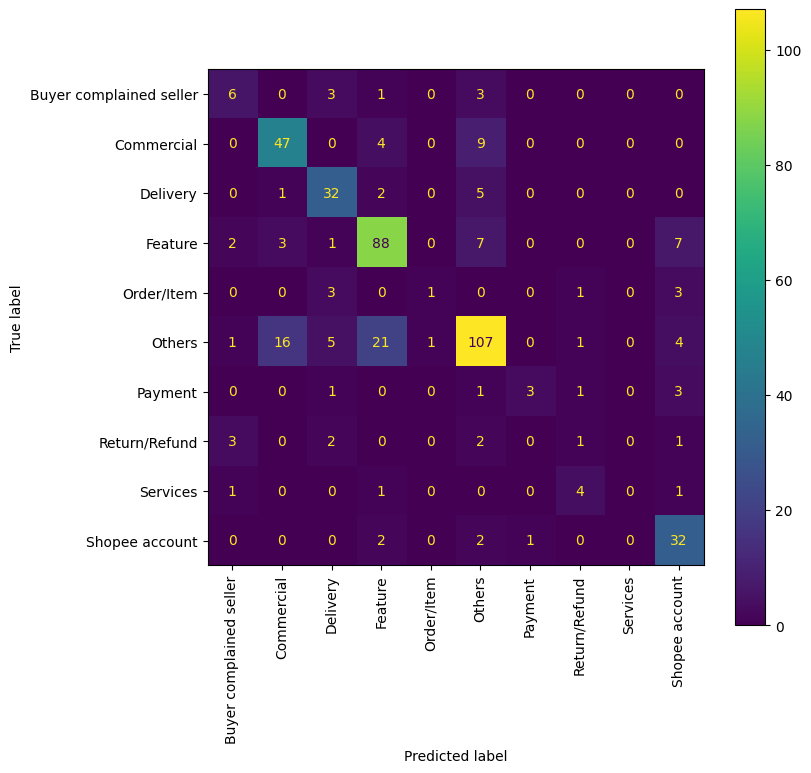


-------------------- label Analysis on metadata: Source --------------------
---------- Distribution ----------
             count  proportion
Source                        
google play    280    0.626398
non owned      102    0.228188
owned           25    0.055928
ios             24    0.053691
hc search       16    0.035794

---------- Metrics for each value in Source ----------
- For all data:
f1_score: 0.4952 . accuracy_score: 0.7092 . 
- For google play:
f1_score: 0.4857 . accuracy_score: 0.6929 . 
- For hc search:
f1_score: 0.4315 . accuracy_score: 0.6250 . 
- For ios:
f1_score: 0.6736 . accuracy_score: 0.7083 . 
- For non owned:
f1_score: 0.3407 . accuracy_score: 0.7647 . 
- For owned:
f1_score: 0.4146 . accuracy_score: 0.7200 . 

--------------- Let's look at some wrong predictions with high confidence ---------------
Text: google play - đcm quảng cáo cc à
True label: Others, but predict Commercial, with confidence 0.9892
------------------------------------------------------

In [ ]:
evaluate_classification_model(df_val,label_name='label',
                              text_name='text',
                              pred_name='pred_L1',
                              prob_name='pred_prob_L1',
                              metric_funcs=metric_funcs,
                              metadatas='Source',
                              cm_figsize=(8,8),
                              n_show=5
                             )

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()